In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot,EnhancerDatasetWithID
import pandas as pd
from tqdm import tqdm
import glob
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3,DeepSTARR


In [3]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_G+G-/ExplaiNN3_G+G-_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 75]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 75
target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 75
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 350
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 77.9823
Epoch 1/200 -- Train Loss: 75.7963 , Validation Loss: 73.9910
------------------------Evaluation------------------------
Label 1: MSE=75.3632, RMSE=8.6812, MAE=8.6765, R^2=-1283.0421, Pearson=0.1684, Spearman=0.1369
Label 2: MSE=72.6136, RMSE=8.5214, MAE=8.5171, R^2=-1971.6928, Pearson=0.0051, Spearman=-0.0196
Overall (Flattened): MSE=73.9884, RMSE=8.6017, MAE=8.5968, R^2=-1487.1457, Pearson=0.0583, Spearman=0.0267
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 73.8278
Epoch 2/200 -- Train Loss: 71.6121 , Validation Loss: 70.5060
------------------------Evaluation------------------------
Label 1: MSE=71.9591, RMSE=8.4829, MAE=8.4784, R^2=-1225.0437, Pearson=0.2785, Spearman=0.2367
Label 2: MSE=69.0403, RMSE=8.3090, MAE=8.3047, R^2=-1874.6145, Pearson=0.0456, Spearman=0.0231
Overall (Flattened): MSE=70.4

In [6]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/best_pearson*.pth')

# Function to evaluate the model with a specific set of weights
def evaluate_model_with_weights(model, test_loader, weight_file):
    # Load the saved weights
    model.load_state_dict(torch.load(weight_file))
    
    # Set model to evaluation mode
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_fragment_ids = []

    # Disable gradient calculation for inference
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, fragment_ids = data  # Get inputs, labels, and fragment IDs
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            
            # Store predictions, true labels, and fragment IDs
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_fragment_ids.append(fragment_ids)  # Keep track of the sample IDs

    # Convert lists of numpy arrays into a single numpy array
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_fragment_ids = np.concatenate(all_fragment_ids, axis=0)
    
    return all_predictions, all_labels, all_fragment_ids

# Loop over each weight file and evaluate the model
for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
    predictions, labels, fragment_ids = evaluate_model_with_weights(input_model, test_loader, weight_file)
    
    # Prepare DataFrame columns for each label
    data = {
        'Fragment_ID': fragment_ids
    }
    # Assume two labels, handle each as separate columns
    for i in range(len(target_labels)):
        data[f'Predictions_{target_labels[i]}'] = predictions[:, i]
        data[f'True_{target_labels[i]}'] = labels[:, i]
    
    # Create DataFrame from the dictionary
    df_predictions = pd.DataFrame(data)
    
    # Save results to a CSV file
    output_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/prediction_results.csv'
    df_predictions.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")


Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/best_pearson_model_epoch_131.pth
Results saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/prediction_results.csv


# Train ExplaiNN Predict GFP+

In [ ]:
# Directory to save the result
seed = 42
batch = 168
num_cnns = 90
learning_rate= 5e-5
target_labels = ["GFP+"]
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP+_90NN'

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

In [ ]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP+_90NN/best_r2*.pth')

# Function to evaluate the model with a specific set of weights
def evaluate_model_with_weights(model, test_loader, weight_file):
    # Load the saved weights
    model.load_state_dict(torch.load(weight_file))
    
    # Set model to evaluation mode
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_fragment_ids = []

    # Disable gradient calculation for inference
    with torch.no_grad():
        for data in test_loader:
            inputs, labels, fragment_ids = data  # Get inputs, labels, and fragment IDs
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            
            # Store predictions, true labels, and fragment IDs
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_fragment_ids.append(fragment_ids)  # Keep track of the sample IDs

    # Convert lists of numpy arrays into a single numpy array
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_fragment_ids = np.concatenate(all_fragment_ids, axis=0)
    
    return all_predictions, all_labels, all_fragment_ids

# Loop over each weight file and evaluate the model
for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
    predictions, labels, fragment_ids = evaluate_model_with_weights(input_model, test_loader, weight_file)
    
    # Print or save results
    df_predictions = pd.DataFrame({
        'Fragment_ID': fragment_ids,  # Add the fragment IDs
        'Predictions': predictions.flatten(),  # Assuming 1D output
        'True Labels': labels.flatten()
    })
    
    # Save results to a CSV file
    output_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP+_90NN/prediction_results.csv'
    df_predictions.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")


# Train DeepSTARR

In [9]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-/DeepSTARR_G+G-_Metrics.csv')

temp_df = params

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Pred'

print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr



input_model = DeepSTARR(num_classes = 2)

_, _, model_deepstarr, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

lr: 0.005    drop_out: 0.3
batch: 96    seed: 41
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 73.8624
Epoch 1/200 -- Train Loss: 8.7961 , Validation Loss: 1.5739
------------------------Evaluation------------------------
Label 1: MSE=1.6504, RMSE=1.2847, MAE=1.1259, R^2=-27.1203, Pearson=0.1113, Spearman=0.1103
Label 2: MSE=1.5006, RMSE=1.2250, MAE=1.0608, R^2=-39.7670, Pearson=0.0696, Spearman=0.0771
Overall (Flattened): MSE=1.5755, RMSE=1.2552, MAE=1.0934, R^2=-30.6889, Pearson=0.0924, Spearman=0.0944
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 1.2274
Epoch 2/200 -- Train Loss: 1.0644 , Validation Loss: 0.8769
------------------------Evaluation------------------------
Label 1: MSE=0.8549, RMSE=0.9246, MAE=0.8229, R^2=-13.5655, Pearson=0.1957, Spearman=0.1773
Label 2: MSE=0.9013, RMSE=0.9493, MAE=0.8487, R^2=-23.4845, Pearson=0.1725, Spearman=0.1509
Overall (Flattened): MSE=0.8781, RMSE=0.9371, MAE=0.8358, R^2

In [18]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Pred/best_pearson*.pth')

# Loop over each weight file and evaluate the model
for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
    predictions_d, labels_d, fragment_ids_d  = evaluate_model_with_weights(input_model, test_loader, weight_file)
    
    # Prepare DataFrame columns for each label
    data = {
        'Fragment_ID': fragment_ids
    }
    # Assume two labels, handle each as separate columns
    for i in range(len(target_labels)):
        data[f'Predictions_{target_labels[i]}'] = predictions_d[:, i]
        data[f'True_{target_labels[i]}'] = labels_d[:, i]
    
    # Create DataFrame from the dictionary
    df_predictions_d = pd.DataFrame(data)
    
  

#for weight_file in file_list:
#    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
#    predictions_d, labels_d, fragment_ids_d = evaluate_model_with_weights(input_model, test_loader, weight_file)
    
    # Print or save results
#    df_predictions_d = pd.DataFrame({
#        'Fragment_ID': fragment_ids_d,  # Add the fragment IDs
#        'Predictions': predictions_d.flatten(),  # Assuming 1D output
#        'True Labels': labels_d.flatten()
#    })
    
    # Save results to a CSV file
    #output_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_70NN/prediction_results.csv'
    #df_predictions.to_csv(output_file, index=False)
    #print(f"Results saved to {output_file}")

Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Pred/best_pearson_model_epoch_39.pth


In [19]:
df_predictions

,Fragment_ID,Predictions_GFP+,True_GFP+,Predictions_GFP-,True_GFP-
0,22_23_07,8.456658,8.376870,8.416374,8.474570
1,16_12_19,8.306081,8.013380,8.272982,8.269110
2,07_15_22,8.525015,8.707065,8.375017,8.276675
3,06_12_17,8.422651,8.471095,8.539032,8.189130
4,05_13_18,8.561261,8.390480,8.403807,8.634430
...,...,...,...,...,...
2141,17_03_03,8.297383,8.583190,8.518169,8.547775
2142,18_21_20,8.510992,8.458300,8.524788,8.437220
2143,07_18_17,8.317275,8.545305,8.271485,8.377095
2144,22_11_08,8.492569,8.011385,8.380289,8.217250


In [20]:
df_predictions_d

,Fragment_ID,Predictions_GFP+,True_GFP+,Predictions_GFP-,True_GFP-
0,22_23_07,8.651258,8.376870,8.587004,8.474570
1,16_12_19,8.561131,8.013380,8.444935,8.269110
2,07_15_22,8.541002,8.707065,8.402889,8.276675
3,06_12_17,8.681411,8.471095,8.540769,8.189130
4,05_13_18,8.512055,8.390480,8.374161,8.634430
...,...,...,...,...,...
2141,17_03_03,8.809498,8.583190,8.731718,8.547775
2142,18_21_20,8.520204,8.458300,8.410578,8.437220
2143,07_18_17,8.407804,8.545305,8.282471,8.377095
2144,22_11_08,8.529445,8.011385,8.414526,8.217250


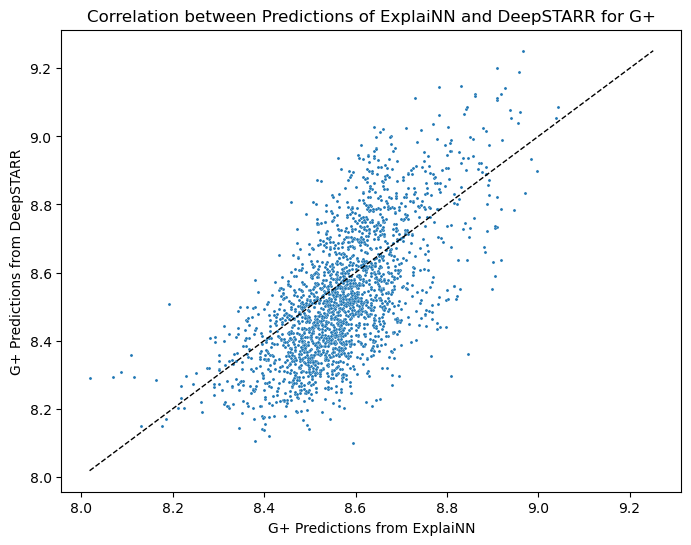

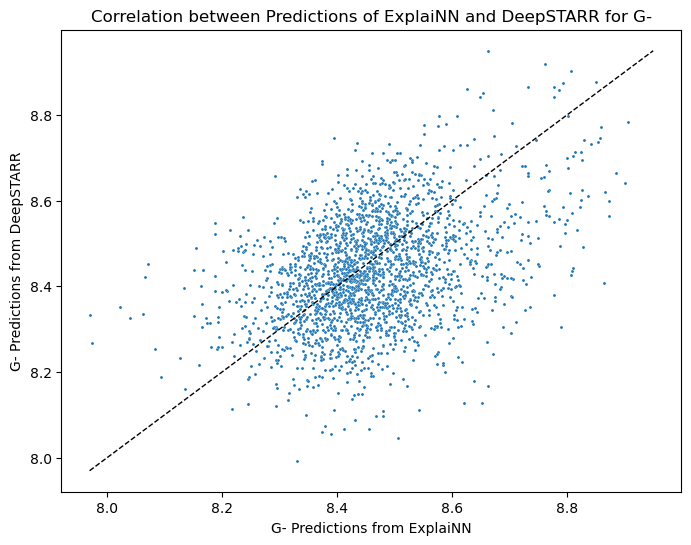

Pearson correlation for Predictions_GFP+: 0.6580358965133423
Pearson correlation for Predictions_GFP-: 0.39412667492676384


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for Predictions_GFP+
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_predictions_d['Predictions_GFP+'], y=df_predictions['Predictions_GFP+'], s=5)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP+'].min(), df_predictions['Predictions_GFP+'].min())
max_val = max(df_predictions_d['Predictions_GFP+'].max(), df_predictions['Predictions_GFP+'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G+ Predictions from ExplaiNN')
plt.ylabel('G+ Predictions from DeepSTARR')
plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G+')

# Show the plot
plt.show()

# Plot for Predictions_GFP-
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_predictions_d['Predictions_GFP-'], y=df_predictions['Predictions_GFP-'], s=5)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP-'].min(), df_predictions['Predictions_GFP-'].min())
max_val = max(df_predictions_d['Predictions_GFP-'].max(), df_predictions['Predictions_GFP-'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G- Predictions from ExplaiNN')
plt.ylabel('G- Predictions from DeepSTARR')
plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G-')

# Show the plot
plt.show()

from scipy.stats import pearsonr

# Calculate Pearson correlation for Predictions_GFP+
correlation_gfp_plus, _ = pearsonr(df_predictions_d['Predictions_GFP+'], df_predictions['Predictions_GFP+'])
print(f"Pearson correlation for Predictions_GFP+: {correlation_gfp_plus}")

# Calculate Pearson correlation for Predictions_GFP-
correlation_gfp_minus, _ = pearsonr(df_predictions_d['Predictions_GFP-'], df_predictions['Predictions_GFP-'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")

